# US Road Accidents – Geospatial EDA


In [ ]:
# !pip install geopandas shapely folium

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

# For interactive maps
import folium
from folium.plugins import HeatMap

# Optional: for optimization with large data
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

# 2. Display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


In [ ]:
DATA_PATH = '/content/drive/MyDrive/RoadSafety_Nov25/data/raw/US_Accidents_March23.csv'

# Load a sample if running locally with limited RAM
USE_SAMPLE = True
SAMPLE_FRAC = 0.1  # 10% sample

df = pd.read_csv(DATA_PATH)

if USE_SAMPLE:
    df = df.sample(frac=SAMPLE_FRAC, random_state=42).reset_index(drop=True)

df.shape, df.head()


### Basic Overview and Geospatial Fields
- The dataset includes start latitude/longitude for each accident, plus state/city and other attributes

In [ ]:
df.info()
df.describe(include='all').T.head(20)

# Important geospatial & contextual columns (adjust depending on version)
geo_cols = [
    "ID", "Severity", "Start_Time", "End_Time",
    "Start_Lat", "Start_Lng", "End_Lat", "End_Lng",
    "City", "County", "State", "Zipcode"
]
[col for col in geo_cols if col in df.columns]

df[geo_cols].head()

- Check missingness focused on spatial fields.

In [ ]:
geo_subset = df[["Start_Lat", "Start_Lng", "City", "County", "State"]]
geo_subset.isna().mean().sort_values(ascending=False)

### Create GeoDataFrame
- Convert latitude/longitude into geometry points suitable for spatial analysis

In [ ]:
# Drop rows with missing start coordinates (core for spatial map)
df_geo = df.dropna(subset=['Start_Lat', 'Start_Lng']).copy()

# Create Shapely geometry
geometry = [Point(xy) for xy in zip(df_geo["Start_Lng"], df_geo['Start_Lat'])]

gdf = gpd.GeoDataFrame(
    df_geo,
    geometry = geometry,
    crs = "EPSG:4326"
)
gdf.head(), gdf.crs

- Optionally, reproject to a projected CRS for distance/area-based analysis.

In [ ]:
# Example: USA Contiguous Albers Equal Area projection
gdf_proj = gdf.to_crs(epsg=5070)
gdf_proj.crs

### 5. Macro Spatial Distribution
 - Accidents by State and City

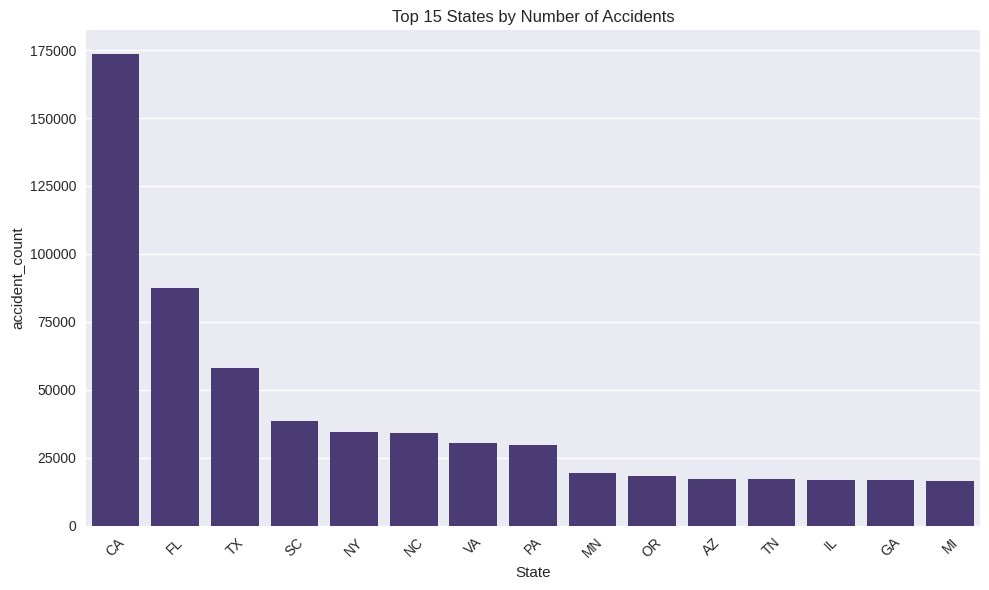

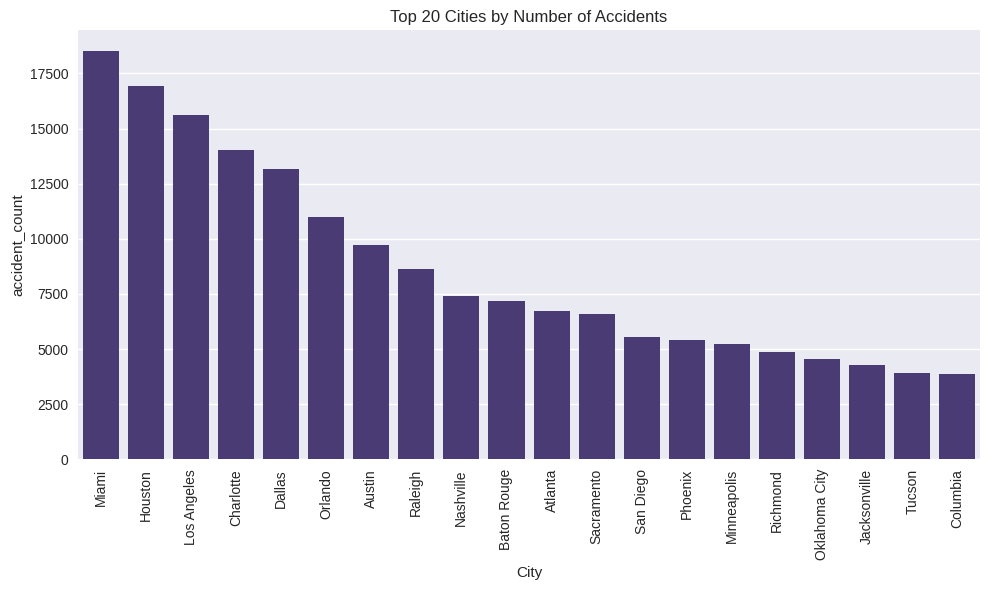

In [ ]:
# Accidents count by state
state_counts = gdf["State"].value_counts().reset_index()
state_counts.columns = ["State", "accident_count"]

plt.figure(figsize=(10, 6))
sns.barplot(data=state_counts.head(15), x="State", y="accident_count")
plt.title("Top 15 States by Number of Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Accidents count by city
city_counts = gdf["City"].value_counts().reset_index()
city_counts.columns = ["City", "accident_count"]

plt.figure(figsize=(10, 6))
sns.barplot(data=city_counts.head(20), x="City", y="accident_count")
plt.title("Top 20 Cities by Number of Accidents")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 6. Static Geospatial Plots
- For dense data, sample points for plotting to avoid overplotting.

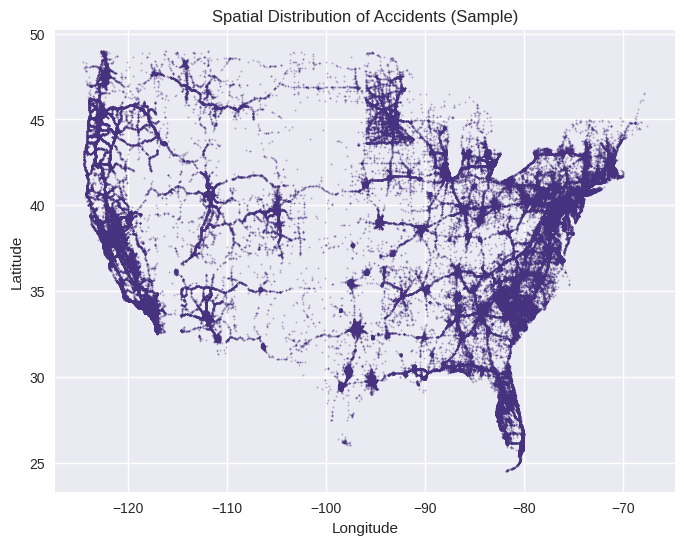

In [ ]:
# Sample for visualization
PLOT_SAMPLE = 1000_000
gdf_sample = gdf.sample(
    n=min(PLOT_SAMPLE, len(gdf)),
    random_state=42
)

# Scatter plot of accidents by coordinates
plt.figure(figsize=(8, 6))
plt.scatter(
    gdf_sample["Start_Lng"],
    gdf_sample["Start_Lat"],
    s=1,
    alpha=0.3
)
plt.title("Spatial Distribution of Accidents (Sample)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

- Accidents by severity in space:

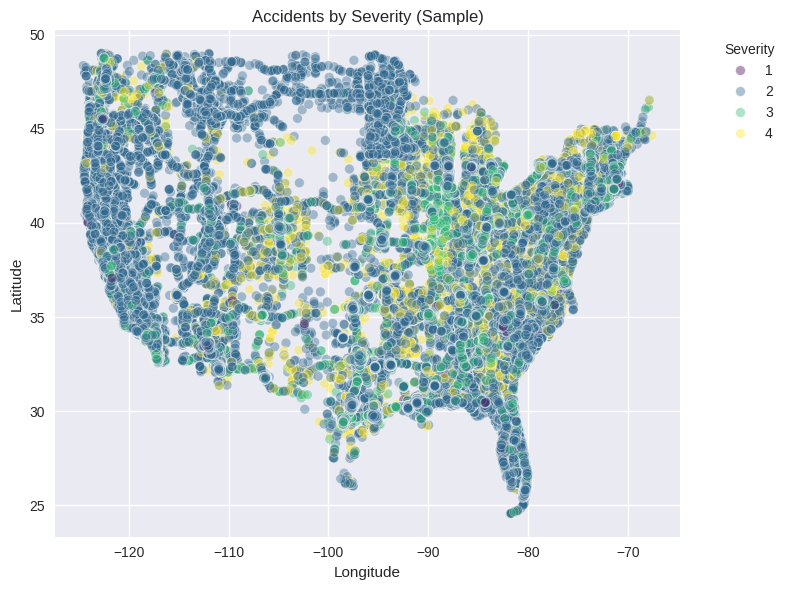

In [ ]:
if "Severity" in gdf_sample.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=gdf_sample,
        x="Start_Lng",
        y="Start_Lat",
        hue="Severity",
        size=None,
        alpha=0.4,
        palette="viridis",
        legend="full"
    )
    plt.title("Accidents by Severity (Sample)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(title="Severity", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


### 7. Choropleth by State
- Load a US states boundary shapefile/GeoJSON (e.g., from natural earth or census TIGER) and join with counts.

        featurecla  scalerank  LABELRANK                SOVEREIGNT SOV_A3  \
4  Admin-0 country          1          2  United States of America    US1   

   ADM0_DIF  LEVEL     TYPE TLC                     ADMIN ADM0_A3  GEOU_DIF  \
4         1      2  Country   1  United States of America     USA         0   

                    GEOUNIT GU_A3  SU_DIF        SUBUNIT SU_A3  BRK_DIFF  \
4  United States of America   USA       0  United States   USA         0   

                       NAME      NAME_LONG BRK_A3       BRK_NAME BRK_GROUP  \
4  United States of America  United States    USA  United States      None   

   ABBREV POSTAL                 FORMAL_EN FORMAL_FR     NAME_CIAWF NOTE_ADM0  \
4  U.S.A.     US  United States of America      None  United States      None   

  NOTE_BRK                 NAME_SORT NAME_ALT  MAPCOLOR7  MAPCOLOR8  \
4     None  United States of America     None          4          5   

   MAPCOLOR9  MAPCOLOR13          POP_EST  POP_RANK  POP_YEAR    GDP_M

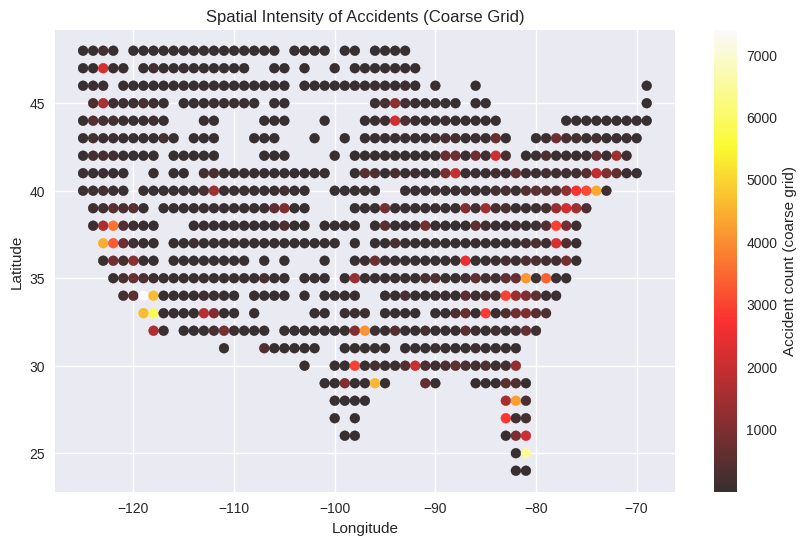

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. (Optional) world / USA layer from Natural Earth
#    – not strictly needed for the grid plot,
#      but kept here as a working replacement.
# --------------------------------------------------
# Natural Earth admin-0 countries, 1:110m
world_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_url)

# Column name can be NAME_EN or NAME depending on version; adjust if needed
name_col = "NAME_EN" if "NAME_EN" in world.columns else "NAME"
usa = world[world[name_col] == "United States of America"]

print(usa.head())
print(usa.crs)

# --------------------------------------------------
# 2. Assume you already have a GeoDataFrame gdf
#    with Start_Lat and Start_Lng columns.
#    Create a sample for plotting.
# --------------------------------------------------
PLOT_SAMPLE = 200_000
gdf_sample = gdf.sample(
    n=min(PLOT_SAMPLE, len(gdf)),
    random_state=42
).copy()

# --------------------------------------------------
# 3. Coarse grid binning (1-degree cells)
# --------------------------------------------------
GRID_SIZE = 1.0  # 1-degree grid

gdf_sample["lat_bin"] = (gdf_sample["Start_Lat"] // GRID_SIZE) * GRID_SIZE
gdf_sample["lng_bin"] = (gdf_sample["Start_Lng"] // GRID_SIZE) * GRID_SIZE

grid_counts = (
    gdf_sample
    .groupby(["lat_bin", "lng_bin"])
    .size()
    .reset_index(name="count")
)

# --------------------------------------------------
# 4. Coarse grid intensity plot
# --------------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(
    grid_counts["lng_bin"],
    grid_counts["lat_bin"],
    c=grid_counts["count"],
    s=50,
    cmap="hot",
    alpha=0.8
)
plt.colorbar(label="Accident count (coarse grid)")
plt.title("Spatial Intensity of Accidents (Coarse Grid)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### 8. Interactive Folium Maps
- 8.1 Base Map with Points

In [ ]:
# Center map around continental US
center_lat = gdf["Start_Lat"].mean()
center_lng = gdf["Start_Lng"].mean()

m_points = folium.Map(location=[center_lat, center_lng], zoom_start=4, tiles="CartoDB positron")

# Use smaller sample for interactive plotting
INTERACTIVE_SAMPLE = 20_000
gdf_int = gdf.sample(n=min(INTERACTIVE_SAMPLE, len(gdf)), random_state=42)

for _, row in gdf_int.iterrows():
    folium.CircleMarker(
        location=[row["Start_Lat"], row["Start_Lng"]],
        radius=2,
        color="blue",
        fill=True,
        fill_opacity=0.5
    ).add_to(m_points)

m_points


Output hidden; open in https://colab.research.google.com to view.

- 8.2 Heatmap of Accident Density

In [ ]:
m_heat = folium.Map(location=[center_lat, center_lng], zoom_start=4, tiles="CartoDB dark_matter")

heat_data = gdf_int[["Start_Lat", "Start_Lng"]].values.tolist()
HeatMap(heat_data, radius=7, blur=10).add_to(m_heat)

m_heat


### 9. Spatial–Temporal Patterns
- Accident hotspots by hour of day or by season in specific metro areas.

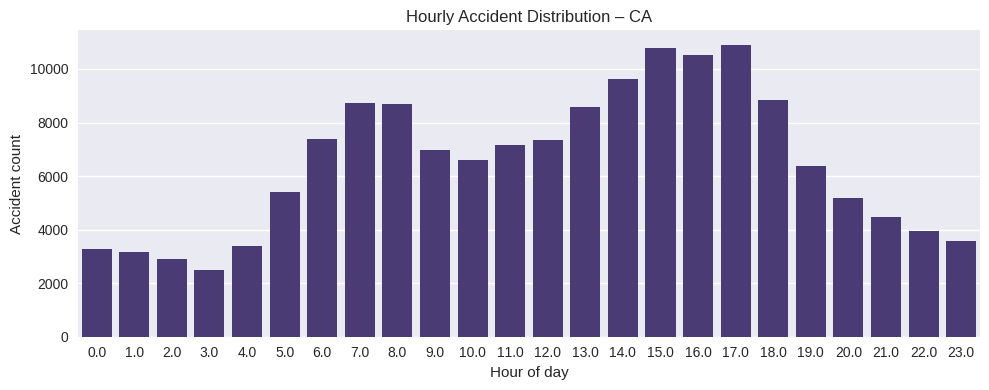

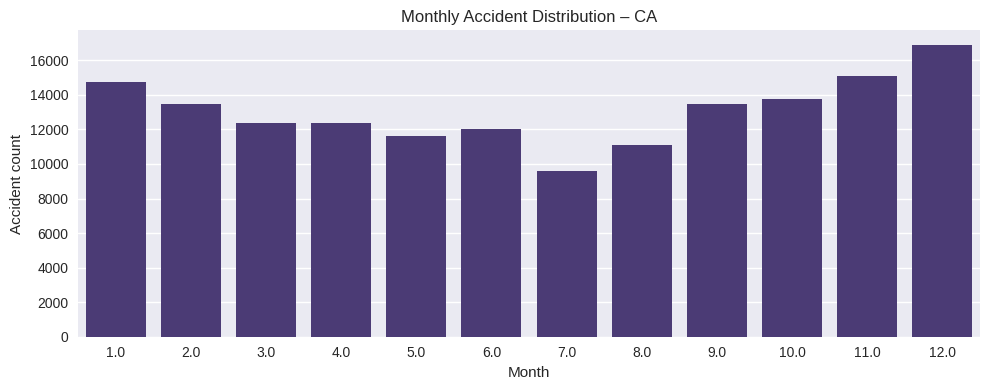

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------
# 1. Datetime parsing (robust)
# ------------------------------
# Option A: let pandas infer and coerce bad rows
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce")

# If you want stricter control, you can instead strip the fractional seconds:
# df["Start_Time_clean"] = df["Start_Time"].astype(str).str.split(".").str[0]
# df["Start_Time"] = pd.to_datetime(df["Start_Time_clean"],
#                                   format="%Y-%m-%d %H:%M:%S",
#                                   errors="coerce")

# Create time features
df["hour"] = df["Start_Time"].dt.hour
df["month"] = df["Start_Time"].dt.month

# ------------------------------
# 2. Make sure gdf has hour/month
# ------------------------------
# If gdf was created earlier from df, re-sync these columns:
if "geometry" in df.columns:
    # If df is already a GeoDataFrame
    gdf = df.copy()
else:
    # If gdf already exists, update its columns from df by index
    gdf["hour"] = df["hour"]
    gdf["month"] = df["month"]

# ------------------------------
# 3. Focus on a specific state
# ------------------------------
target_state = "CA"  # change to any state code present in your data
gdf_state = gdf[gdf["State"] == target_state].copy()

# Drop rows where Start_Time parsing failed
gdf_state = gdf_state.dropna(subset=["Start_Time"])

# ------------------------------
# 4. Hourly distribution plot
# ------------------------------
plt.figure(figsize=(10, 4))
sns.countplot(data=gdf_state, x="hour")
plt.title(f"Hourly Accident Distribution – {target_state}")
plt.xlabel("Hour of day")
plt.ylabel("Accident count")
plt.tight_layout()
plt.show()

# ------------------------------
# 5. Monthly distribution plot
# ------------------------------
plt.figure(figsize=(10, 4))
sns.countplot(data=gdf_state, x="month")
plt.title(f"Monthly Accident Distribution – {target_state}")
plt.xlabel("Month")
plt.ylabel("Accident count")
plt.tight_layout()
plt.show()


### 10. Hotspot Detection (Simple KDE)
- More advanced hotspot detection often uses kernel density estimation or spatial clustering.

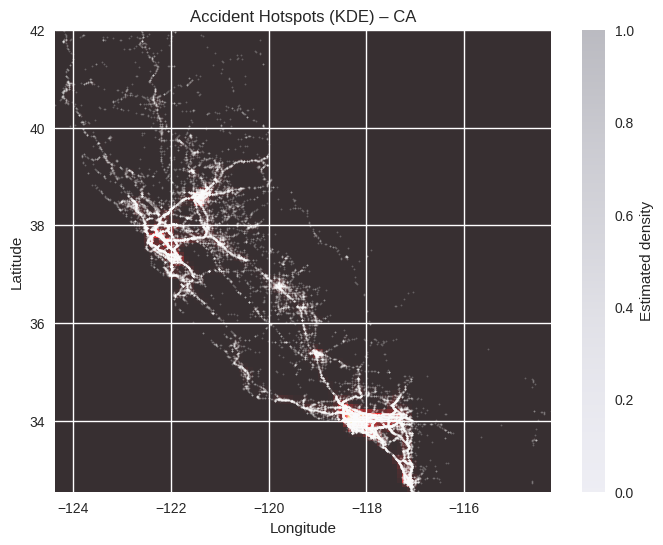

In [ ]:
from sklearn.neighbors import KernelDensity

# Take subset for one city/state for performance
subset = gdf_state.sample(n=min(50_000, len(gdf_state)), random_state=42)

coords = np.vstack([subset["Start_Lat"].values, subset["Start_Lng"].values]).T

kde = KernelDensity(
    bandwidth=0.05,
    kernel="gaussian"
)
kde.fit(coords)

# Evaluate density on a grid
lat_min, lat_max = subset["Start_Lat"].min(), subset["Start_Lat"].max()
lng_min, lng_max = subset["Start_Lng"].min(), subset["Start_Lng"].max()

lat_lin = np.linspace(lat_min, lat_max, 100)
lng_lin = np.linspace(lng_min, lng_max, 100)
lat_grid, lng_grid = np.meshgrid(lat_lin, lng_lin)
grid_coords = np.vstack([lat_grid.ravel(), lng_grid.ravel()]).T

log_dens = kde.score_samples(grid_coords)
dens = np.exp(log_dens).reshape(lat_grid.shape)

plt.figure(figsize=(8, 6))
plt.imshow(
    dens.T,
    origin="lower",
    extent=[lng_min, lng_max, lat_min, lat_max],
    cmap="hot",
    alpha=0.8,
    aspect="auto"
)
plt.scatter(subset["Start_Lng"], subset["Start_Lat"], s=1, alpha=0.2, c="white")
plt.title(f"Accident Hotspots (KDE) – {target_state}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Estimated density")
plt.show()

### 11. Correlating Geospatial and Contextual Features
- Combine spatial location with weather, road type, and urban features to understand risk factors.

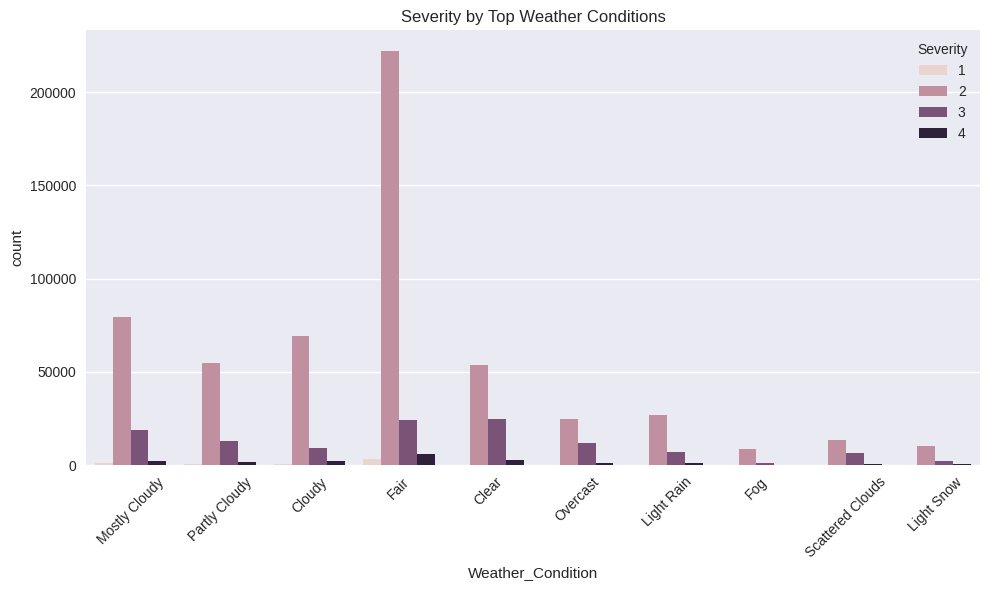

In [ ]:
# Example: accidents by distance from start to end (if available)
if {"Start_Lat", "Start_Lng", "End_Lat", "End_Lng"}.issubset(df.columns):
    # Compute approximate distance with haversine-like approximation (rough)
    R = 6371  # km

    lat1 = np.radians(df["Start_Lat"])
    lat2 = np.radians(df["End_Lat"])
    dlat = lat2 - lat1
    dlon = np.radians(df["End_Lng"] - df["Start_Lng"])

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    df["approx_distance_km"] = R * c

    df["approx_distance_km"].describe()

# Example: severity vs. urban/rural or weather (if columns exist)
cols_to_check = [c for c in ["Severity", "Weather_Condition", "Amenity", "Bump", "Crossing"] if c in df.columns]
df[cols_to_check].head()

if "Weather_Condition" in df.columns:
    plt.figure(figsize=(10, 6))
    top_weather = df["Weather_Condition"].value_counts().head(10).index
    sns.countplot(
        data=df[df["Weather_Condition"].isin(top_weather)],
        x="Weather_Condition",
        hue="Severity"
    )
    plt.xticks(rotation=45)
    plt.title("Severity by Top Weather Conditions")
    plt.tight_layout()
    plt.show()
